<a href="https://colab.research.google.com/github/abhinavsagar/Self-Driving-Car/blob/master/autonomous_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!git clone https://github.com/abhinavsagar/Self-Driving-Car.git

In [ ]:
#!ls Self-Driving-Car

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os
from os.path import join as opj
import time

## Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

print('TF {}'.format(tf.__version__))

#import keras
'''
from tf.keras.models import Sequential
from tf.keras.optimizers import Adam
from tf.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
'''

import cv2
import pandas as pd
import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

IMAGESIZE = 50


## Store data
datadir = 'G:\GIT\carla\data\imageEvents.csv'
columns = ['fileName','throttle','steer','brake','trafficLight']
data = pd.read_csv(datadir, names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()
data.describe()

TF 2.1.0


C:\Users\Stefan\.conda\envs\tf-gpu-cuda10.2\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,throttle,steer,brake
count,309142.000000,309142.000000,309142.000000
mean,0.282794,0.007020,0.343987
std,0.217141,0.094558,0.474950
min,0.000000,-0.800000,0.000000
25%,0.000000,-0.007067,0.000000
50%,0.390000,-0.000006,0.000000
75%,0.420000,0.008339,1.000000
max,0.700000,0.800000,1.000000


[-0.8        -0.62222222 -0.44444444 -0.26666667 -0.08888889  0.08888889
  0.26666667  0.44444444  0.62222222  0.8       ]
[    97    208   3113  11070 273573  14985   3040   1845   1211]
[-1.11111111 -0.84444444 -0.57777778 -0.31111111 -0.04444444  0.22222222
  0.48888889  0.75555556  1.02222222]
0.1777777777777778 0.1777777777777778


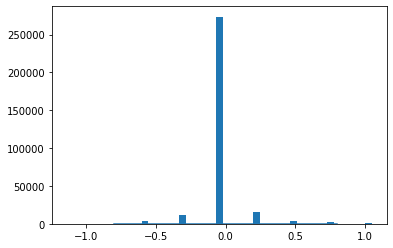

In [2]:
## Visualize data
num_bins = 9
samples_per_bin = 250
hist, bins = np.histogram(data['steer'], num_bins)
center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0

## Plot
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steer']), np.max(data['steer'])), (samples_per_bin, samples_per_bin))
print(bins)
print(hist)
print(center)

print(bins[1]-bins[0],bins[-1]-bins[-2])

In [3]:
data['steer'].head()

dist = 0.4
nb = range(-8,9,int(dist*10))
newBins = [n/10. for n in nb]
num_bins = len(newBins)
newBins

[-0.8, -0.4, 0.0, 0.4, 0.8]

In [4]:
import random

def load_img_steering(df):
  """Get img and steering data into arrays"""  
  steering = {angle:[] for angle in newBins}
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    centerIMG = indexed_data['fileName']
    curSteering = indexed_data['steer']
    
    for bn in range(len(newBins)):
        if curSteering >= newBins[bn] - dist/2 and curSteering <= newBins[bn] + dist/2:
            curSteering = newBins[bn]
            break
    
    steering[curSteering].append(os.path.join('G:\\GIT\\carla\\data\\images', centerIMG))
    
    if curSteering != 0.0:        
        steering[curSteering*-1.0].append(os.path.join('G:\\GIT\\carla\\data\\images', centerIMG+'mirror'))
    
  return steering

steering = load_img_steering(data)
minLen = 999
for key,value in steering.items():
    pass
    minLen = min(minLen,len(value))
    
print(minLen)



choppedSteering = {}
for key,value in steering.items():
    
    if True:
    
        random.shuffle(value)
        value = value[:minLen]

        choppedSteering[key] = value
    

for key,value in choppedSteering.items():
    print(key,len(value))



999
-0.8 999
-0.4 999
0.0 999
0.4 999
0.8 999


Text(0.5, 1.0, 'Validation set')

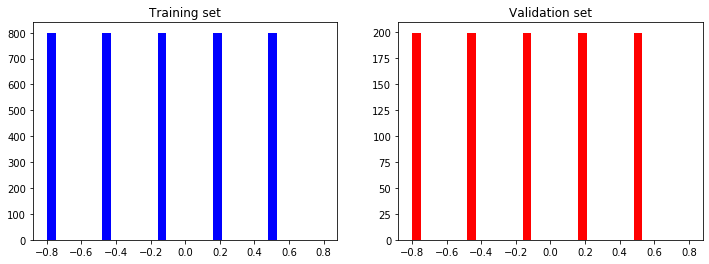

In [5]:
test_size = 0.2
train_size = 1.0-test_size
#splitIndex = minLen*train_size


        
X_train_pathes = []
X_valid_pathes = []
Y_train = []
Y_valid = []

for i in range(minLen):
    for key,value in choppedSteering.items():        
        howMuchValues = len(value)        
        if i >= howMuchValues:
            continue
        
        if i < howMuchValues*train_size:
            X_train_pathes.append(value[i])
            Y_train.append(key)
        else:
            X_valid_pathes.append(value[i])
            Y_valid.append(key)
        

X_train_pathes = np.asarray(X_train_pathes)
X_valid_pathes = np.asarray(X_valid_pathes)
Y_train = np.asarray(Y_train)
Y_valid = np.asarray(Y_valid)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue', align='mid')
axes[0].set_title('Training set')
axes[1].hist(Y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [10]:
def img_preprocess(img):
  # TAKE PATH OF IMAGE
  # RETURN PREPROCESSED IMAGE
    
  readWithMatplotLib = 1   
  
  mirror = 0
  if img.endswith('mirror'):  
    mirror = 1
    img = img.replace('mirror','')

    
  if readWithMatplotLib:
    img = npimg.imread(img)
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  else:
    img = cv2.imread(img,1)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img = img / 255.

  ## Decrease size for easier processing
  img = cv2.resize(img, (IMAGESIZE, IMAGESIZE))
  
  if mirror:
    img = cv2.flip(img, 1)

  return img

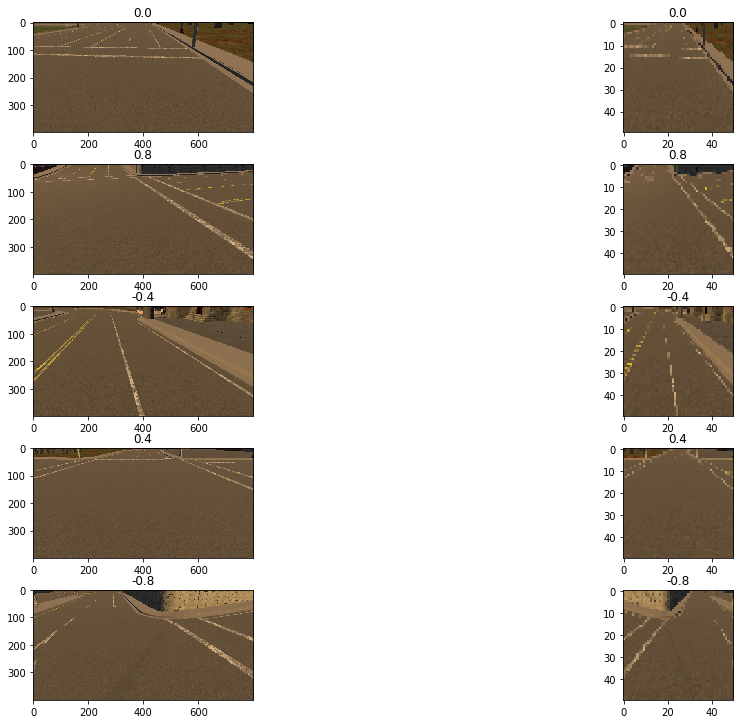

In [11]:
howManyChecks = 5
fig, axes = plt.subplots(howManyChecks, 2, figsize=(15, 10))
fig.tight_layout()

images = []
labels = []

for i in range(0,howManyChecks*2,2):
    
    image = X_train_pathes[102+i]
    lab = Y_train[102+i]
    
    org = npimg.imread(image.replace('mirror',''))
    pre = img_preprocess(image)
    
    images.extend([org,pre])
    labels.append(lab)
    
i = 0
for cnt,a in enumerate(axes):
    for aa in a:    
        aa.imshow(images[i], interpolation='none')
        aa.set_title(labels[cnt])
        i = i+1
        
    

In [12]:
X_train = np.array(list(map(img_preprocess, X_train_pathes)))
X_valid = np.array(list(map(img_preprocess, X_valid_pathes)))

In [13]:
maxVal = -999.0
minVal = 999.0
for pic in X_train:
    maxVal = max(maxVal,np.max(pic))
    minVal = min(minVal,np.min(pic))
    
print(minVal,maxVal)

maxVal = -999.0
minVal = 999.0
for pic in X_valid:
    maxVal = max(maxVal,np.max(pic))
    minVal = min(minVal,np.min(pic))
    
print(minVal,maxVal)

0.0 1.0
0.0 1.0


min 0.07352941483259201 / max 0.9127451181411743
min 0.007843137718737125 / max 0.8058823347091675
min 0.11176471412181854 / max 0.8833333253860474
min 0.0 / max 0.7823529243469238
min 0.007843137718737125 / max 0.8176470994949341
min 0.07254902273416519 / max 0.8598039150238037
min 0.0 / max 0.7519607543945312
min 0.046078432351350784 / max 0.886274516582489
min 0.01764705963432789 / max 1.0
min 0.0 / max 0.9421569108963013


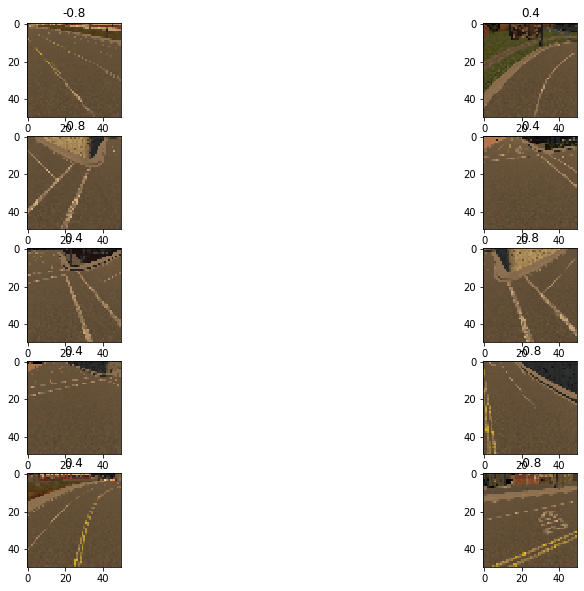

In [14]:
fig, axes = plt.subplots(howManyChecks,2, figsize=(15, 10))

for ax in axes:
    for ay in ax:
        randIndex = random.randint(0, len(X_train)-1)
        curImage = X_train[randIndex]
        
        print('min {} / max {}'.format(np.min(curImage),np.max(curImage)))
        
        ay.imshow(curImage)
        ay.set_title(Y_train[randIndex])
    


In [15]:
from tensorflow.keras.applications import ResNet50
#Load the ResNet50 model
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGESIZE, IMAGESIZE, 3))

In [16]:
# Freeze the layers except the last 4 layers
for layer in resnet.layers[:-4]:
    layer.trainable = False
 
for layer in resnet.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001A6B58DCC88> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001A6A8376888> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001A6B58593C8> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001A6B5C5C7C8> False
<tensorflow.python.keras.layers.core.Activation object at 0x000001A6B5904588> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001A6B594DA08> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001A6B5A421C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001A6B5A58448> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001A6B5BF0D88> False
<tensorflow.python.keras.layers.core.Activation object at 0x000001A6B5BF8888> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001A6B5C0230

In [18]:
def nvidia_model():
  model = Sequential()
  model.add(resnet)

  model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  optimizer = Adam(lr=0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  return model
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               819300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)               

In [19]:
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid), batch_size=8, verbose=1, shuffle=1)

Train on 4000 samples, validate on 995 samples
Epoch 1/20
4000/4000 [==============================] - 11s 3ms/sample - loss: 5.5268 - accuracy: 0.1015 - val_loss: 0.7673 - val_accuracy: 0.0000e+00
Epoch 2/20
4000/4000 [==============================] - 6s 2ms/sample - loss: 1.7328 - accuracy: 0.1250 - val_loss: 0.4292 - val_accuracy: 0.2000
Epoch 3/20
4000/4000 [==============================] - 6s 2ms/sample - loss: 1.0649 - accuracy: 0.1325 - val_loss: 0.3453 - val_accuracy: 0.2000
Epoch 4/20
4000/4000 [==============================] - 6s 2ms/sample - loss: 0.6838 - accuracy: 0.1560 - val_loss: 0.3339 - val_accuracy: 0.2000
Epoch 5/20
4000/4000 [==============================] - 6s 2ms/sample - loss: 0.5056 - accuracy: 0.1772 - val_loss: 0.3245 - val_accuracy: 0.2000
Epoch 6/20
4000/4000 [==============================] - 6s 2ms/sample - loss: 0.3996 - accuracy: 0.1947 - val_loss: 0.3214 - val_accuracy: 0.2000
Epoch 7/20
4000/4000 [==============================] - 6s 2ms/sample - 

Text(0.5, 0, 'Epoch')

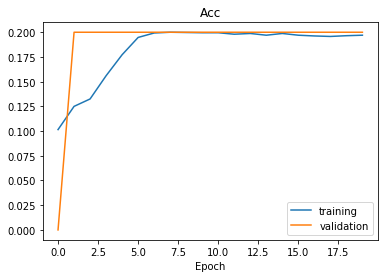

In [20]:
'''
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
'''
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Acc')
plt.xlabel('Epoch')

In [21]:

modelName = opj('g:\\git\\carla\\','{}_{}_acc_{:.2f}_valAcc_{:.2f}.h5'.format(time.time(),IMAGESIZE,history.history['accuracy'][-1],history.history['val_accuracy'][-1]))

model.save(modelName)
os.getcwd()

'G:\\git\\Self-Driving-Car'

In [22]:
loadedModel = tf.keras.models.load_model(modelName)
#loadedModel = tf.keras.models.load_model('G:\\GIT\\carla\\1588424374.248614_50_acc_0.11_valAcc_0.11.h5')

G:\GIT\carla\data\images\1588088106.98_t0.00_s-0.0068592_b1.0_r.png
0.0
0.8647059
[[0.03857051]]
0.05802011489868164


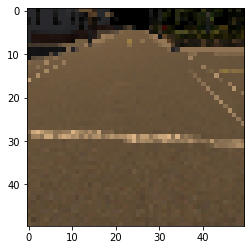

In [24]:
picDir = 'G:\\GIT\\carla\\data\\images'

allpics = [opj(picDir,pic) for pic in os.listdir(picDir)]

random.shuffle(allpics)
startTime = time.time()
for i in range(1):
    
    testPic = allpics[i]
    print(testPic)
    pi = img_preprocess(testPic)
    
    print(np.min(pi))
    print(np.max(pi))
    
    plt.imshow(pi)
    pi = np.expand_dims(pi, axis=0)
    pred = loadedModel.predict(pi)

    print(pred)

print(time.time()-startTime)
